In [3]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import fastai
from datetime import datetime
import spacy
from tqdm.auto import tqdm
from html.parser import HTMLParser
import re


# Only using tokenization for now
nlp = spacy.load('en_core_web_sm', parser=False, entity=False)

tqdm.pandas()

font_size = '20.0'
dark_theme_config = {
    "ytick.color" : "w",
    "xtick.color" : "w",
    "text.color": "white",
    'font.size': font_size,
    'axes.titlesize': font_size,
    'axes.labelsize': font_size, 
    'xtick.labelsize': font_size, 
    'ytick.labelsize': font_size, 
    'legend.fontsize': font_size, 
    'figure.titlesize': font_size,
    'figure.figsize': [20, 7],
    'figure.facecolor': "#384151",
    'legend.facecolor': "#384151",
    "axes.labelcolor" : "w",
    "axes.edgecolor" : "w"
}
sns.set(rc=dark_theme_config)
plt.rcParams.update(dark_theme_config)

In [4]:
ls data/

reddit_200k_test.csv         reddit_test.csv
reddit_200k_train.csv        reddit_train.csv
reddit_200k_train_clean.csv  rscience-popular-comment-removal.zip


# Load Data
The files seemed to have mixed encoding, but we wanted to make  

In [5]:
df_200_cols = ["prev_idx", "body", "score", "parent_id", "id", "created_date", "retrieved_date", "removed"]
df_200_test = pd.read_csv("data/reddit_200k_test.csv", 
                          names=df_200_cols, skiprows=1, encoding="ISO-8859-1")
df_200_train = pd.read_csv("data/reddit_200k_train.csv", 
                           names=df_200_cols, skiprows=1, encoding="ISO-8859-1")

df_30_cols = ["prev_idx", "x", "body", "removed"]
df_30_test = pd.read_csv("data/reddit_test.csv", 
                         names=df_30_cols, skiprows=1, encoding="ISO-8859-1")
df_30_train = pd.read_csv("data/reddit_train.csv", 
                          names=df_30_cols, skiprows=1, encoding="ISO-8859-1")

# Groupingg to make exploration easier
all_dfs = [
    df_30_train,
    df_30_test,
    df_200_train,
    df_200_test,
]

In [6]:
html_parser = HTMLParser()
uplus_pattern = re.compile("<[uU]\+(?P<digit>[a-zA-Z0-9]+)>")
def fix_encoding(raw):
    try:
        decoded = raw.encode("ISO-8859-1").decode("utf-8")
    except:
        decoded = raw.encode("ISO-8859-1").decode("cp1252")
    html_unescaped = html_parser.unescape(decoded) 
    html_unescaped = html_unescaped.replace("\r\n", " ")
    html_unescaped = uplus_pattern.sub(" U+\g<digit> ", html_unescaped)
    html_unescaped = html_unescaped.replace("\\", "")
    return html_unescaped
        
for df in all_dfs:
    df["body"] = df["body"].progress_apply(fix_encoding)

/home/alejandro/anaconda3/envs/reddit-classification/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  


In [7]:
df_30_test.head()

,prev_idx,x,body,removed
0,8312,8428,Is there any veracity to the claims that peopl...,0
1,22499,23448,"Welcome to the 1980's, Head of NASA",1
2,20709,21465,Hold on while I stroke my ego,1
3,11582,11745,I wonder if this is associated with majority o...,0
4,19743,20386,"So, just like everyone, everywhere, then?",1


In [8]:
df_200_test.head()

,prev_idx,body,score,parent_id,id,created_date,retrieved_date,removed
0,1,"Hi Larpo_Nadar, your submission has been remov...",0,t3_74udg6,do15nly,1507377013,1509603985,True
1,2,"So out of every 10,000 children with autism wh...",8,t3_879uw5,dwc3dps,1522107010,1525623538,False
2,3,"When I was pregnant, I was warned against eati...",4,t3_5qo49s,dd1wtw2,1485686073,1486529379,False
3,4,Imagine if this find was the bug that eradicat...,14,t3_5qmr9c,dd0qpcr,1485618726,1486509114,True
4,5,Is it a myth that the math says it would take ...,0,t3_6wtiwg,dmb0sg4,1504050679,1504495504,False


# High level qualitative analysis
Before starting exploratory data analysis, we'll have a quick look at some of the examples, and ask a few questions about what the data is and what the columns mean.

Some of the questions that arise initially are:
* What is the difference between the reddit_ and reddit_200k_? 
    * Are these disjoint datasets or is the former a subset?
* Are there significant imbalances for example on target function?
* What do the REMOVED posts look like (e.g. intuitives, gotchas, etc)?
* Are there many missing / empty rows? 
* What do posts with high/low scores look like?
* Are there any class imbalances in the data (length, examples, etc)?
* It seems that parent_id and id are not compatible, so parents won't be in df 
    
Let's start with these in order.

## Difference between 200k and 30k DFs
I want to understand whether the datasets from 200k and 30k are disjoint or they actually are the same dataset. To verify we'll try to match some columns from the 30k with the 200k. 

We will first attempt to merge/join using the index column provided, which may be a unique identifier (As the 30k train/test index is not in order)

In [9]:
df_200_train.copy().merge(df_30_train, on="prev_idx", how="inner")

,prev_idx,body_x,score,parent_id,id,created_date,retrieved_date,removed_x,x,body_y,removed_y
0,1,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False,1,This is a far reaching problem that goes beyon...,0
1,3,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True,3,Anecdotal evidence and some emerging research ...,0
2,4,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False,4,"""This study provided evidence that fasting ind...",0
3,5,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False,5,Tobacco is not just nicotine; it also contains...,0
4,6,So when we can remember a history where he sha...,4,t3_69fya9,dh6bkbf,1494006743,1496285592,False,6,Grad student in cognitive neuroscience here. T...,0
5,7,Keep going! So close to a 100% run.,110,t3_926dfb,e33l7ug,1532647663,1536705787,True,7,I would have more faith in this study if it we...,0
6,8,"Rains here just start, no buildup.. one or two...",2,t3_9dzqzm,e5lmvpe,1536388817,1538826252,True,8,It's called a frill shark for those interested...,0
7,10,"Hi BocceBaller42, your post has been removed f...",2,t3_5r1nu1,dd3pv7z,1485793932,1486560607,False,10,What is the airspeed velocity of an unladen sw...,0
8,11,Kinda what happens when people think morality ...,8,t3_897pfk,dwq79ih,1522760848,1525907694,False,11,I thought models where saying weather will bec...,0
9,12,This sounds like an answer we would arrive at ...,-6,t3_92lntd,e36lekj,1532781451,1536789657,True,12,"Well this pops up from time to time, but accor...",0


The previous index is clearly not a consistent identifier across the datasets, so we'll attempt to merge using the body/text.

### Number of repeated comments

In [10]:
for df in all_dfs:
    vcs = df["body"].value_counts()
    print(vcs.tolist()[:10])
    print([v[:20]+"..." for v in vcs.keys().tolist()[:5]])

[3, 2, 2, 1, 1, 1, 1, 1, 1, 1]
['Why is every comment...', 'Why are so many comm...', 'Why is everything re...', 'Hello! So there is a...', 'The moral of most of...']
[2, 2, 2, 1, 1, 1, 1, 1, 1, 1]
['Why the fuck is ever...', 'Why are so many comm...', 'Why are so many comm...', 'You can be really ol...', 'Interesting read, th...']
[28, 20, 17, 10, 8, 7, 7, 6, 6, 6]
['Your submission has ...', 'Why are so many comm...', 'This submission has ...', 'Why is everything re...', 'Why is every comment...']
[10, 10, 6, 4, 3, 3, 3, 2, 2, 2]
['This submission has ...', 'Why are so many comm...', 'Your submission has ...', "That is why I can't ...", 'Correlation does not...']


Small note: Interesting to see many of the common comments are notices of removed submissions and complaints of many comments being removed.

In [11]:
results = []
i = 0
while i < len(all_dfs) - 1:
    j = i + 1
    while j < len(all_dfs):
        print("Inner: ", i,
              ", ", all_dfs[i].shape[0],
              "\tOuter: ", j,
              ", ", all_dfs[j].shape[0],
              ". \tSHAPE RESULT: ",
              all_dfs[i].copy()
                  .merge(all_dfs[j], on="body", how="inner").shape[0])
        j += 1
    i += 1

Inner:  0 ,  21336 	Outer:  1 ,  7111 . 	SHAPE RESULT:  9
Inner:  0 ,  21336 	Outer:  2 ,  167529 . 	SHAPE RESULT:  15079
Inner:  0 ,  21336 	Outer:  3 ,  55843 . 	SHAPE RESULT:  5016
Inner:  1 ,  7111 	Outer:  2 ,  167529 . 	SHAPE RESULT:  5043
Inner:  1 ,  7111 	Outer:  3 ,  55843 . 	SHAPE RESULT:  1694
Inner:  2 ,  167529 	Outer:  3 ,  55843 . 	SHAPE RESULT:  969


### 30k dataset seems to be a subset of 200k subset
It seems that based on joining the dataframes on the body, the number of resulting examples is almost the same (there is a discrepancy that may be caused due to the repeated comments as well as potential comments that are not present but the number is quite small and we can proceed with only the 200k dataset given that it has a larger number of richer features.

In [12]:
df = pd.concat([df_200_train, df_200_test])
# We also drop the index provided as it's of no use
df = df.drop(["prev_idx"], axis=1)
df.head()

,body,score,parent_id,id,created_date,retrieved_date,removed
0,I've always been taught it emerged from the ea...,2,t3_81u15i,dv551g6,1520121101,1524782256,False
1,"As an ECE, my first feeling as ""HEY THAT'S NOT...",2,t3_72sk35,dnl66g6,1506533157,1507150439,True
2,Monday: Drug companies stock dives on good new...,5,t3_8o88yr,e02sjhz,1528087570,1532170350,True
3,i learned that all hybrids are unfertile i won...,0,t3_6xg9t8,dmfojjp,1504290041,1506407514,False
4,Well i was wanting to get wasted tonight. Not...,3,t3_99wi9m,e4rtew8,1535140675,1537893540,False


### Assessing basics (target imbalance, NAs, etc)

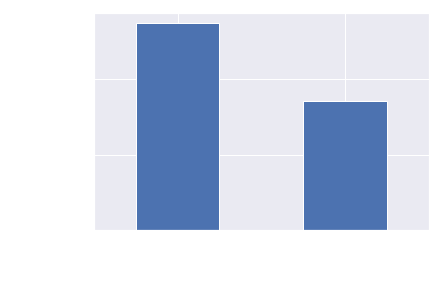

In [14]:
df["removed"].value_counts().plot.bar()

There doesn't seem to be a significant imbalance initially at least in terms of the number of examples 

In [15]:
df["body"].isna().sum()
df[df["body"].str.len() < 4]

,body,score,parent_id,id,created_date,retrieved_date,removed
6159,duh,2,t3_6gzd50,div89k7,1497394968,1499324703,True
38206,Duh,2,t3_88ys8z,dwp1s0x,1522704371,1525878427,True
45078,,17,t3_6hm34x,dizc1vw,1497616522,1499396818,False
100607,The,2,t3_8n3s00,dzsltoo,1527638663,1528136552,True
156869,LOL,0,t3_6erjjd,dickqjk,1496374018,1498995408,True
3372,Bop,0,t3_91s3jt,e30ryea,1532542777,1536625825,True
44721,Lol,0,t3_6erjjd,dicm661,1496376096,1498996097,True
50960,#LA,0,t3_9ash9u,e4y32nd,1535413825,1537998877,True


In [16]:
# Check number of instances with just URLs
simple_url_regex = "^\s*(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})\s*$"
df[df["body"].replace(simple_url_regex, "", regex=True)
    .str.len() < 4]

,body,score,parent_id,id,created_date,retrieved_date,removed
801,http://www.nature.com/ng/journal/vaop/ncurrent...,2,t3_6m1d0x,djy4kyr,1499525489,1501065256,False
1862,http://www.cell.com/cell-reports/abstract/S221...,3,t3_67o9vf,dgrvv91,1493214978,1494394259,False
1900,http://www.pnas.org/content/early/2017/01/01/1...,3,t3_5lyh1u,dbze4qr,1483526760,1485765990,False
4154,http://www.thelancet.com/journals/lancet/artic...,0,t3_5wkau3,deaq9aw,1488238154,1489194363,False
5043,https://www.livescience.com/60847-charm-quark-...,0,t3_7aoyqx,dpbpu92,1509773856,1512112315,False
5166,https://link.springer.com/article/10.1007%2Fs1...,0,t3_60uabk,df9a9sq,1490185809,1491691618,False
5971,https://academic.oup.com/jac/article-abstract/...,-4,t3_5psnbl,dcthg59,1485215081,1486302287,False
5984,http://onlinelibrary.wiley.com/doi/10.1111/pal...,3,t3_5vc52i,de0u3mh,1487691686,1489020884,False
6159,duh,2,t3_6gzd50,div89k7,1497394968,1499324703,True
6691,http://www.eso.org/public/archives/releases/sc...,2,t3_5yfi6v,depjkh0,1489071638,1491341002,False


In [17]:
df[df["body"].str.contains("â")].values

array([['The title of the post is a copy and paste from the second paragraph of the linked academic press release here :  > Their study found that a single dose of cannabidiol in rats with symptoms of depression was highly effective, eliminating the symptoms on the same day and maintaining the beneficial effects for a week.    Journal Reference:  Amanda J. Sales, Manoela V. Fogaça, Ariandra G. Sartim, Vitor S. Pereira, Gregers Wegener, Francisco S. Guimarães, Sâmia R. L. Joca.   Cannabidiol Induces Rapid and Sustained Antidepressant-Like Effects Through Increased BDNF Signaling and Synaptogenesis in the Prefrontal Cortex.   Molecular Neurobiology, 2018;   DOI: 10.1007/s12035-018-1143-4  Link: https://link.springer.com/article/10.1007%2Fs12035-018-1143-4  Abstract  Currently available antidepressants have a substantial time lag to induce therapeutic response and a relatively low efficacy. The development of drugs that addresses these limitations is critical to improving public health. C

# Insight from comments
> An insightful quote says "Hours of trial and error can save you a several minutes reading documentation". Because of this, we'll dive on the Reddit API documentation to understand whether some of the columns are explained there. https://www.reddit.com/dev/api/


In [41]:
import praw

reddit = praw.Reddit(
    client_id="UXnyGF_HEzd2Rg",
    client_secret="P6DS8Liqb6U8gC6sXLv1iNiI-LU",
    user_agent='USERAGENT')

In [14]:
comment = reddit.comment("dmfojjp")
comment.body

'i learned that all hybrids are unfertile i wont read clickbaits https://biology.stackexchange.com/questions/16922/why-are-hybrids-infertile'

In [15]:
parent = comment.parent()
print(parent.title)
print(parent.selftext)

Interspecies Hybrids Play a Vital Role in Evolution



## Insights obtained
* Prefix t3_ on ID means that a comment is a topic/submission. Prefix t1_ (or alternatively no suffix as per IDs provided) means that it's a comment within a topic/submission. 
    * This is interesting because all of the comment examples provided have a parent ID with t3_, which means that they are all highest-level comments and there are no examples on 2nd-level+ comments.
    * This is important because the model that we will train with this, may not be efficient when used for comments that are not high level, so it will be quite limited.

## Examples of removed comments


In [18]:
print("\n\n\nNEWPOST\n"
      .join(df[df["removed"] == True]["body"]
            .values[100:300]))

TL;DR most people are followers and can't think for themselves


NEWPOST
People are living very long these days but risk of disease is the highest it's been in decades.


NEWPOST
Maybe so, but they're also more likely to be drought and famine resistant.


NEWPOST
I have a severe peanut/nut allergy (among lots of others) and my elementary school made me sit at a "peanut free" table in the classroom. I was the only person there so that helped making friends, but it would of made me feel better if there were no peanuts/nuts in the school at all, but I also know that is silly.  I totally agree with a "peanut free" table but not with an outright ban.


NEWPOST
I have good health insurance, every time I go to a doctor's office, as soon as they find out I have good insurance they order blood work.


NEWPOST
Reddit: Let's have an open discussion about transgenderism  Also Reddit: The science is settled, if you disagree you're a hateful bigot 


NEWPOST
Well YOU can go fuck yourself!


NEWPOST


### What are the most common repeated in joint DF?

In [19]:
vcs = df["body"].value_counts()[:10]
for k,v in zip(vcs.tolist(), vcs.keys()): print(k, v[:60] + "...")

34 Your submission has been removed because it violates our sub...
30 Why are so many comments removed?...
27 This submission has been automatically removed. Please revie...
11 Why is everything removed?...
10 That is why I can't stand where the marijuana industry is go...
9 Science AMAs are posted early to give readers a chance to as...
9 Why is every comment removed?...
8 Correlation does not equal causation...
7 Correlation does not equal causation....
6 Your submission has been automatically removed because it vi...


#### How many instances of "Your submission has been removed"?

In [20]:
print(df["body"].str.contains("Your submission has been removed").sum())
print(df["body"].str.contains("This submission has been automatically removed").sum())

352
42


In [ ]:
df[df["body"].str.lower().str.contains("why are so many comments")].values

Interesting to see so many comments complaining about comments being removed, some with explanations. Some highlights:
* "Why are so many comments in this thread being removed? You can view them on unreddit and none of them are remotely inappropriate. I can't even figure out what narrative the mods are trying to censor... Its both men and women talking about times they have had sex where they really didn't want to but it was more convenient and easy than refusing. So I guess like, #banreality? Nicely done mods, nicely done. "
* "Why are so many comments being deleted? \r\n\r\nIf people have a different view point let them debate it! \r\n\r\nIf it's an 'inappropriate' joke then please lighten up. "
* "Why are so many comments being deleted? \r\n\r\nIf people have a different view point let them debate it! \r\n\r\nIf it's an 'inappropriate' joke then please lighten up. "
* Why are SO many comments being removed? Does this sub have toxic mods or something?

#### Let's also look what non-removed looks like

In [42]:
df[(df["removed"] == False) & (df["body"].str.contains("idiot")) & (df["body"].str.len() < 100)]["body"].values

array(["This is a sign of global warming. Just for you idiots who can't understand basic science know. ",
       'Too bad some idiots elected fuckwads from that 16%',
       '/u/drumsarelife vaccinate iiiidiot',
       'No wonder there are idiots everywhere with ties and suits',
       'You would to if you were surrounded by idiots.  Imagine how Einstein felt.',
       'And now some idiots will push for regulations "for the common good".',
       'If they are accidental deaths then we should be happy because guns are killing off the idiots.',
       "i'd say seattle is skewing the results, because seattle is populated with idiots. ",
       "I can't wait until we don't have to worry about these antivax idiots.",
       'This is why I am pro GMO. When idiots denounce GMO it makes me sad and angry. ',
       'r/science is just r/weed now, hope you all enjoy being stoners, idiots.',
       'Only idiots buy your climate change bull shit ',
       "That's an idiotic idea.",
       'When mil

There are clearly several false negatives

In [45]:
def print_like(s):
    print(df[df["body"].str.contains(s)]["body"].values)
    reddit_id = df[df["body"].str.contains(s)]["id"].values[0]
    comment = reddit.comment(reddit_id)
    print(comment.parent().title, "\n\n")
    
print_like("That's why I shoot deer")
print_like("What's wrong with a")

["That's why I shoot deer, to help the US beef industry to maintain sustainability and help the enviroment."]
A model for ‘sustainable’ US beef production - If Americans reduced their mean beef consumption from the current ≈460 g per person per week to ≈200 g per person per week (corresponding to f = 0.5), the US beef industry could become environmentally sustainable. 


["What's wrong with a little rape once and a while?"
 "What's wrong with a subreddit about a town of raccoons?"]
Dutch cities that opened legal prostitution zones saw reductions in sexual abuse and rape by about 30-40 percent in the first two years 




### Relevant insights identified
* Although an obvious point, there are false negatives in the training dataset, which means noise is added. There is also semi-false positive examples where either there could be a bias with a specific moderator, or there is not enough context for an ambiguous post (which could be deemed not removed/removed in different contexts which are not provided
* There are posts in format "Hi X, your submission has been removed for the following reason(s)", which may not be useful.
* There are context specific posts that may not be possible to identify without having previous posts or further context outside itself such as "The remaining ingredients are cheese and ground beef.  Earth is like a giant Hot Pocket."
    * More importantly, on repeated texts, some are removed whilst others aren't so removing them may end in better results
* There are URL-encrypted such as "&" (i.e. "&amp;") - some of them are only a URL, which should probably be removed from dataset
* Smileys will have to be parsed by the tokenizer

#### Action points from insights:
* Count number of "Hi X, your submission has been removed...", as this would be relative to N/As / Missing data

##### To address in pre-processing (post-data analysis)
* Address the issue with repeated texts 
* Check if parent posts are available to use as features
* Ensure URL-encrypted symbols + smileys are addressed

<hr>

## Exploratory data analysis for body

In [22]:
def clean_component(raw):
    return nlp(raw, disable=['parser', 'tagger', 'ner'])

df_nlp = df["body"].progress_apply(clean_component)

# Experimenting with multiple tokenization approaches
We'll try multiple different tokenization techniques. Normally stop words and punctuations are removed, but in this case they may be important. Several tries include:
* Removing punctuation and stopwords, but this leaves with very little content
* Result was to leave everything and only tokenize all URLs to URL. There may be a smarter way to categorize URL as several types of URLs (e.g. GOOGLE_URL, REDDIT_URL, OTHER_URL, etc).

In [24]:
def simple_token(doc):
    return [token.lemma_.lower().strip()
                for token in doc]

def alphanum_nostop(doc):
    return [token.lemma_.lower().strip()
                for token in doc
                if (token.is_alpha
                        or token.like_num)
                        and not token.is_stop]

def simple_token_punct(doc):
    return [token.lemma_.lower().strip()
                if not token.like_url else "URL"
                for token in doc
                if not token.is_punct]

symbols = set("!$%^&*()_+|~-=`{}[]:\";'<>?,./-")
def simple_token_url(doc):
    return [token.lemma_.lower().strip()
                if not token.like_url else "URL"
                for token in doc
                if not token.text in symbols]

test_str = nlp("WHAT THE Test? This is definitely!!!! A test. \
Here is a link https://google.com/this/is/a/url LEETS Seeee\
www.mypage.com <- but how not. check this link\
HOw Th!s G0ez LOL LMFAO TL;DR!!11!!1 :) -_- >.< 😃")

print("SIMPLE TOKEN: ",simple_token(test_str))
print("\n\nALPHANUM + NO_STOP: ", alphanum_nostop(test_str))
print("\n\nALPHANUM + NO_STOP: ", simple_token_punct(test_str))
print("\n\nALPHANUM + NO_STOP: ", simple_token_url(test_str))

SIMPLE TOKEN:  ['what', 'the', 'test', '?', 'this', 'be', 'definitely', '!', '!', '!', '!', 'a', 'test', '.', 'here', 'be', 'a', 'link', 'https://google.com/this/is/a/url', 'leets', 'seeeewww.mypage.com', '<', '-', 'but', 'how', 'not', '.', 'check', 'this', 'linkhow', 'th!s', 'g0ez', 'lol', 'lmfao', 'tl;dr!!11!!1', ':)', '-_-', '>.<', '😃']


ALPHANUM + NO_STOP:  ['what', 'the', 'test', 'this', 'definitely', 'a', 'test', 'here', 'link', 'leets', 'check', 'linkhow', 'lol', 'lmfao']


ALPHANUM + NO_STOP:  ['what', 'the', 'test', 'this', 'be', 'definitely', 'a', 'test', 'here', 'be', 'a', 'link', 'URL', 'leets', 'URL', '<', 'but', 'how', 'not', 'check', 'this', 'linkhow', 'th!s', 'g0ez', 'lol', 'lmfao', 'tl;dr!!11!!1', '>.<', '😃']


ALPHANUM + NO_STOP:  ['what', 'the', 'test', 'this', 'be', 'definitely', 'a', 'test', 'here', 'be', 'a', 'link', 'URL', 'leets', 'URL', 'but', 'how', 'not', 'check', 'this', 'linkhow', 'th!s', 'g0ez', 'lol', 'lmfao', 'tl;dr!!11!!1', ':)', '-_-', '>.<', '😃']


In [25]:
symbols = set("!$%^&*()_+|~-=`{}[]:\";'<>?,./-")
def get_token(doc):
    tokens = []
    for token in doc:
        if token.like_url:
            clean_token = "URL"
        else:
            clean_token = token.lemma_.lower().strip()
            if len(clean_token) < 1 or clean_token in symbols: 
                continue
        tokens.append(clean_token)
    return tokens

df_token = df_nlp.progress_apply(get_token)

In [26]:
df_token.head()

0    [-pron-, have, always, be, teach, it, emerge, ...
1    [as, a, ece, my, ﻿1, feel, a, hey, that, 's, n...
2    [monday, drug, company, stock, dive, on, good,...
3    [i, learn, that, all, hybrid, be, unfertile, i...
4    [well, i, be, want, to, get, waste, tonight, n...
Name: body, dtype: object

In [27]:
df_len = df_token.progress_apply(len)

In [28]:
df_len.describe()

count    223372.000000
mean         40.931348
std          61.826789
min           0.000000
25%          11.000000
50%          21.000000
75%          45.000000
max        3151.000000
Name: body, dtype: float64

In [29]:
h=np.histogram(df_len, bins=20)
print(list(h[0]))
print(list(h[1]))
print((df_len>1000).sum())

[214369, 6901, 1503, 388, 118, 47, 22, 10, 5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0.0, 157.55, 315.1, 472.65000000000003, 630.2, 787.75, 945.3000000000001, 1102.8500000000001, 1260.4, 1417.95, 1575.5, 1733.0500000000002, 1890.6000000000001, 2048.15, 2205.7000000000003, 2363.25, 2520.8, 2678.3500000000004, 2835.9, 2993.4500000000003, 3151.0]
41


In [30]:
df_token[df_len>600].shape

(246,)

In [31]:
df_token[df_len>600].values

array([list(['john', 'william', 'money', '8', 'july', '1921', '–', '7', 'july', '2006', 'be', 'a', 'URL', 'wiki', 'psychology', 'URL', 'wiki', 'sexology', 'and', 'author', 'specialize', 'in', 'research', 'into', 'sexual', 'URL', 'wiki', 'sexual_identity', 'and', 'biology', 'of', 'URL', 'wiki', 'sex_determination_and_differentiation_(human', 'he', 'be', 'one', 'of', 'the', '\ufeff1', 'scientist', 'to', 'study', 'the', 'psychology', 'of', 'sexual', 'fluidity', 'and', 'how', 'the', 'societal', 'construct', 'of', 'gender', 'affect', 'a', 'individual', 'more', 'recent', 'academic', 'study', 'have', 'criticize', 'money', 'have', 'work', 'in', 'many', 'respect', 'particularly', 'in', 'regard', 'to', 'his', 'involvement', 'with', 'the', 'sex', 'reassignment', 'of', 'david', 'URL', 'wiki', 'URL', 'wiki', 'john_money#cite_note', 'diamond-1', 'and', 'his', 'eventual', 'suicide', 'money', 'have', 'write', 'have', 'be', 'translate', 'into', 'many', 'language', 'and', 'include', 'around', '2,000', '

There seems to be very few examples with length over 1000 tokens.

0	138056
30	45545
60	17337
90	7890
120	4686
150	2647
179	1773
209	1267
239	984
269	706
299	595
329	432
359	313
389	235
419	205
448	133
478	106
508	84
538	68
568	59


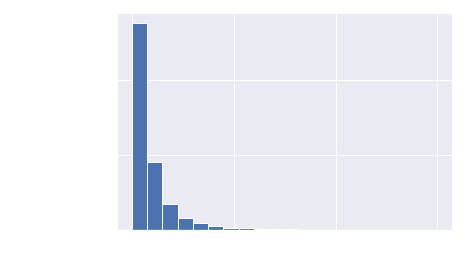

In [32]:
df_len[df_len<600].plot.hist(bins=20) 
hist = np.histogram(df_len[df_len<600], bins=20) 
for k,v in zip(hist[1], hist[0]):
    print(f'{k:.0f}\t{v}')

There seems to be quite a long tail, so perhaps removing the datapoints in the longer tail end might help in the training to avoid outliers

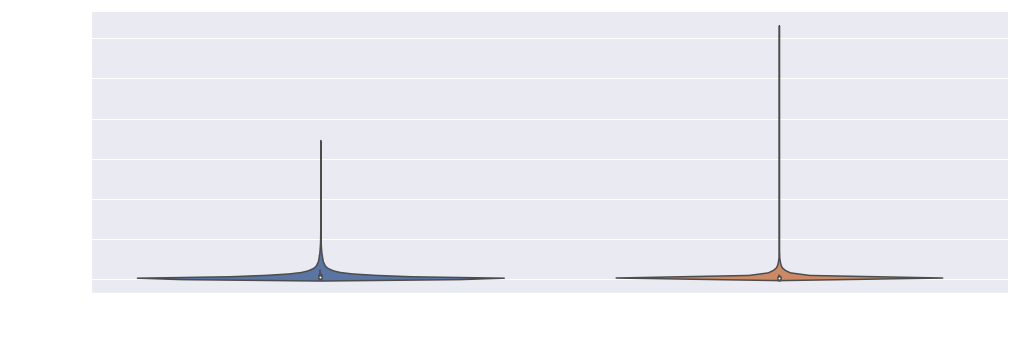

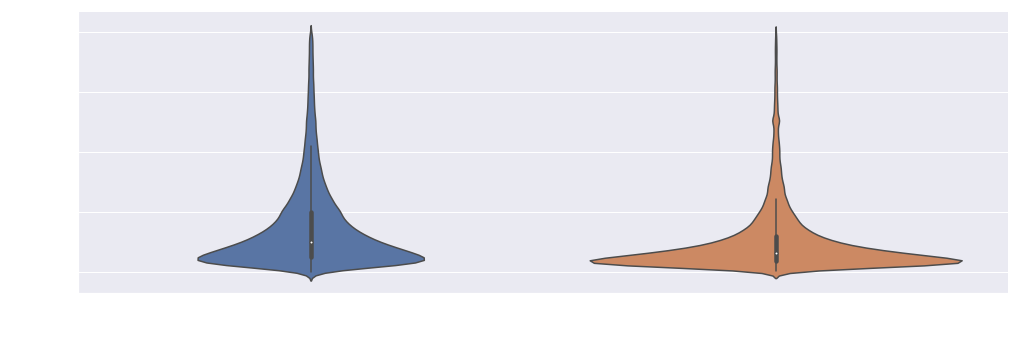

In [33]:
df_extended = df.copy()
df_extended["len"] = df_len
sns.catplot(x="removed", y="len", data=df_extended, kind="violin", aspect=20/7)
plt.show()
sns.catplot(x="removed", y="len", data=df_extended[(df_len<200)], kind="violin", aspect=20/7)

## Exploratory data analysis for Score

In [26]:
# Check if the score is related 
df["score"].describe()

count    223372.000000
mean         41.916288
std         361.810806
min        -236.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       32740.000000
Name: score, dtype: float64

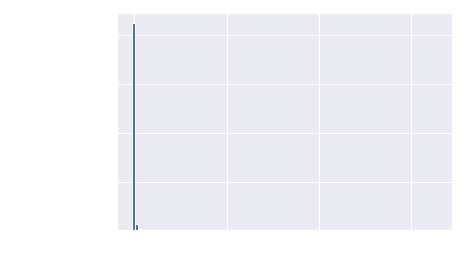

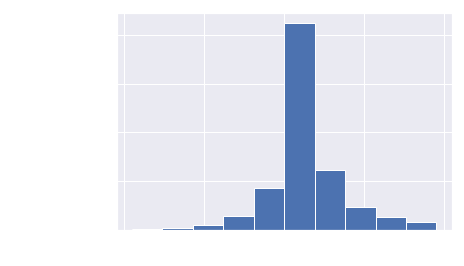

In [27]:
df["score"].plot.hist(bins=100)
plt.show()
df[(df["score"] < 20) & (df["score"] > -20)]["score"].plot.hist(bins=10)

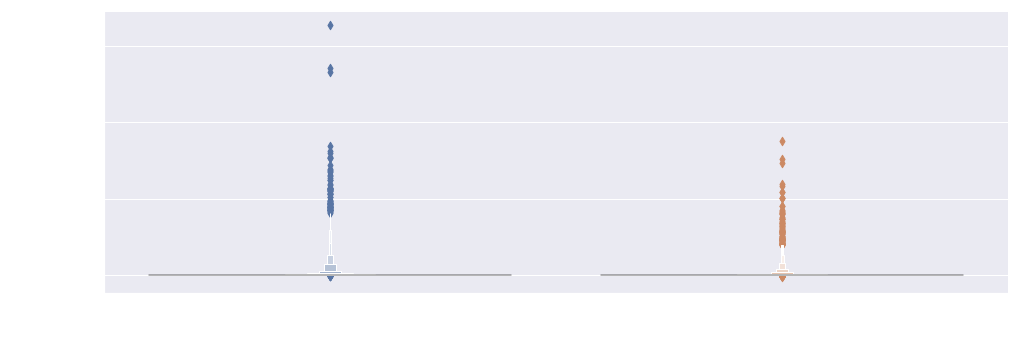

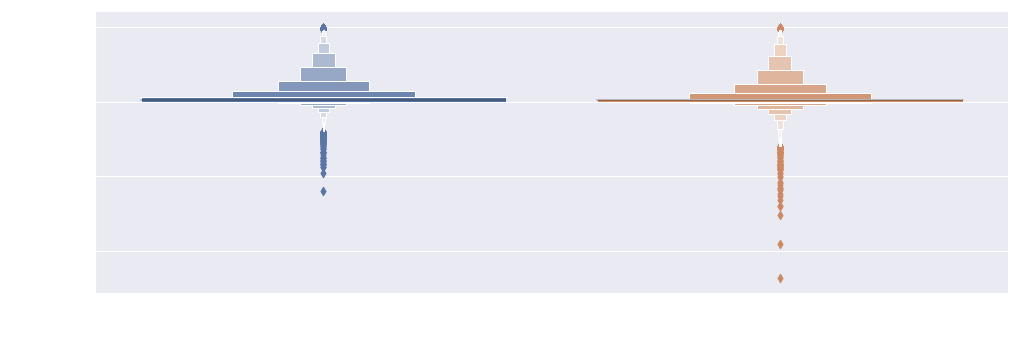

In [28]:
sns.catplot(x="removed", y="score", data=df, kind="boxen", aspect=20/7)
plt.show()
sns.catplot(x="removed", y="score", data=df[df["score"] < 100], kind="boxen", aspect=20/7)

In [70]:
df[((df["score"] > 100) & (df["removed"] == True))].shape

(3521, 7)

# What is the distribution of the dates?

In [47]:
df_dates = df["created_date"].progress_apply(datetime.fromtimestamp)

In [48]:
df_dates.describe()

count                  223372
unique                 222421
top       2017-06-03 15:52:40
freq                       11
first     2017-01-01 00:00:34
last      2018-10-01 00:55:43
Name: created_date, dtype: object

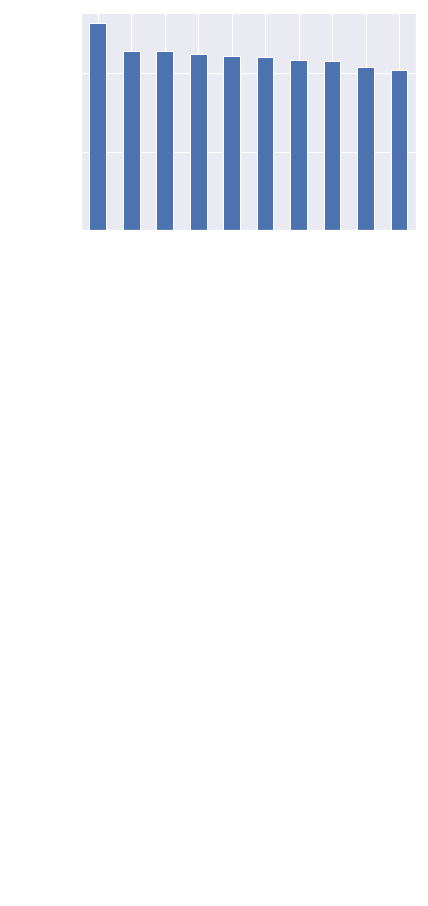

In [49]:
df_dates.value_counts(bins=10).plot.bar()

In [50]:
def time_day(date):
    if date.hour < 12 and date.hour > 4:
        return "MORNING"
    elif date.hour <= 12 and date.hour < 18:
        return "AFTERNOON"
    return "EVENING"
df_time_day = df_dates.apply(time_day)

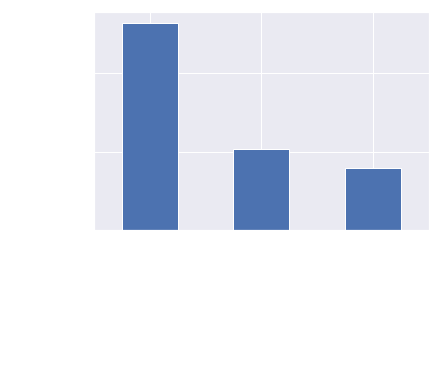

In [51]:
df_time_day.value_counts().plot.bar()

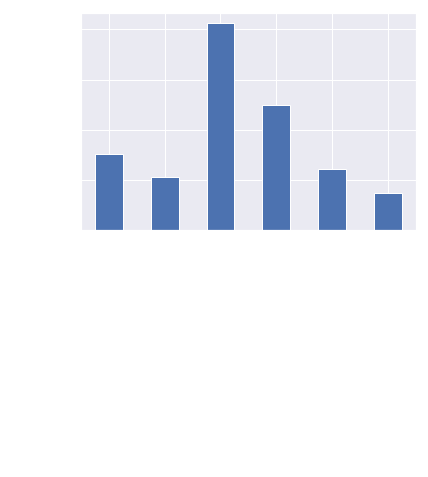

In [70]:
df_extended["time_day"] = df_time_day.values
df_extended.groupby(["time_day", "removed"]).count()["body"].plot.bar()

In [58]:
df_time_day_hour = df_dates.progress_apply(lambda x: x.hour)

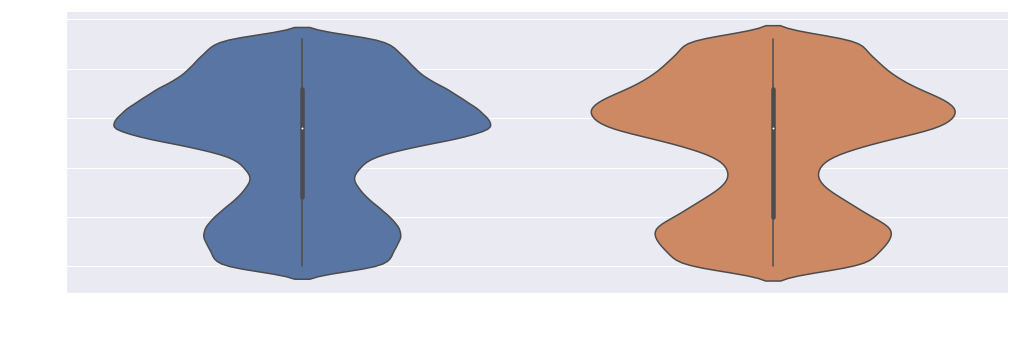

In [64]:
df_extended["time_day_hour"] = df_time_day_hour.values
sns.catplot(x="removed", 
            y="time_day_hour", 
            data=df_extended, 
            kind="violin", 
            aspect=20/7)

## No immediate relevance on retrieved_date

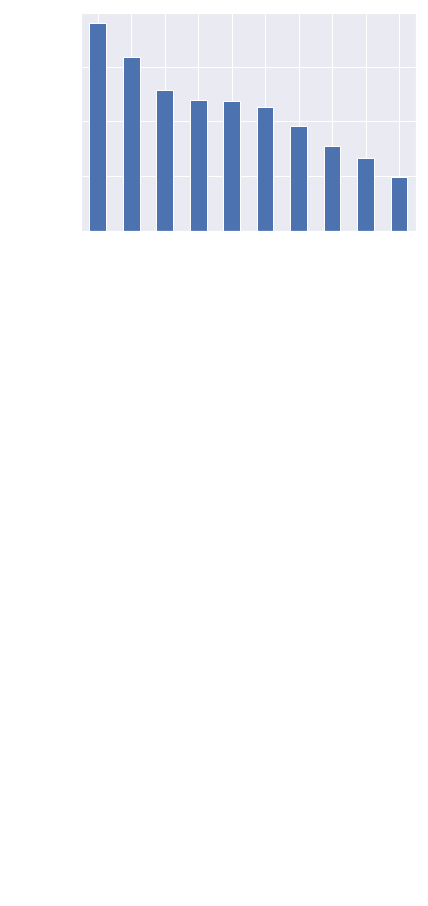

In [46]:
df_dates = df["retrieved_date"].progress_apply(datetime.fromtimestamp)
df_dates.value_counts(bins=10).plot.bar()

It seems that there does seem to be a longer skew towards negative for removed comments. It may be useful to use score as perhaps some correlations can be extrapolated by the model.

In [32]:
# df["body"].isna().sum()

In [33]:
# df[df["body"].str.len() < 4]

In [34]:
# df[df["body"].str.contains("^\s*$")]

In [35]:
# df["body"].replace('^\s*$', np.nan, regex=True, inplace=True)

# simple_url_regex = "^\s*(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})\s*$"
# df["body"].replace(simple_url_regex, np.nan, regex=True, inplace=True)

# df.dropna(inplace=True)